* to do : add perf rel, add ic 

In [1]:
import win32com.client
import calendar
import time
import pytz
import pandas as pd
import os
import datetime
from datetime import datetime, timedelta
import psutil
import xlwings as xw
from sqlalchemy import create_engine
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import statistics
import statsmodels.api as sm
import argparse
import pymssql
import scipy
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression  # Import the LinearRegression class
import seaborn as sns

pd.set_option('display.max_columns', None)

In [6]:
def get_pms_db_engine():
    '''
    set the sql engine that can get the data of PMS
    '''
    PWD = "fmZjbspEm5*zztS%vQ/E.-b&F"
    USER = "ls_fact_gfagq"
    SERVER = "wmsscpram"
    PORT = "1463"
    DATABASE = "pms"
    l_connexionstring = (
        f"mssql+pymssql://{USER}:{PWD}@{SERVER}:{PORT}/{DATABASE}"
    )
    l_engine = create_engine(l_connexionstring)
    return l_engine


def get_Compo_portfolio_pms_data(IdPMS_portfolio ,IdPMS_Benchmark , from_date,to_date,IdPMS_factors, Bystep, ByCurrency  ):
    '''
    IdPMS_portfolio - str : id of the portfolio in PMS
    IdPMS_Benchmark - str : id of the benchmark ni PMS
    from_date - str : beginning date
    to_date - str : end date
    IdPMS_factors - str : PMS.GICS2_VV,PMS.6335 id of factors in pms
    Bystep - str : frequency
    ByCurrency - str : currency
    '''
    return pd.read_sql(
        f"exec spR_ExtractReferentiel '{IdPMS_portfolio}' ,'{IdPMS_Benchmark}' ,'{from_date}' ,'{to_date}', '{IdPMS_factors}' , '{Bystep}','{ByCurrency}'",
        get_pms_db_engine(),
    )

def ptf_mod_perf(bench_code, date1, date2):
    """
    """

    # Define the SQL queries for both dates
    query1 = f"SELECT BenchPrice FROM OPT_IndexPrice WHERE IndexCode = '{bench_code}' AND DateVal = '{date1}'"
    query2 = f"SELECT BenchPrice FROM OPT_IndexPrice WHERE IndexCode = '{bench_code}' AND DateVal = '{date2}'"
    

    result1 = pd.read_sql(query1, get_pms_db_engine())
    result2 = pd.read_sql(query2, get_pms_db_engine())
    
    # Close the engine
    get_pms_db_engine().dispose()
    
    # Extract the BenchPrice values
    bench_price1 = result1['BenchPrice'].iloc[0] if not result1.empty else None
    bench_price2 = result2['BenchPrice'].iloc[0] if not result2.empty else None
    
    # Calculate the change
    if bench_price1 is not None and bench_price2 is not None and bench_price2 != 0:
        change = (bench_price1 / bench_price2) - 1
        return change, bench_price1, bench_price2
    else:
        return None  # Return None if any price is missing or if division by zero


from datetime import datetime, timedelta

def get_fridays(bgn_date, end_date=None):
    '''
    Get a list of Fridays between two dates. If end_date is None, use the date 30 days before bgn_date and result a friday
    '''
    # Convert bgn_date from string to datetime if it's a string
    if isinstance(bgn_date, str):
        bgn_date = datetime.strptime(bgn_date, '%Y-%m-%d')
    
    # If end_date is None, set it to 30 days before bgn_date
    if end_date is None:
        end_date = bgn_date - timedelta(days=30)
    
    fridays = []
    
    current_date = bgn_date
    while current_date >= end_date:  # Change to >= to find Fridays going backwards
        if current_date.weekday() == 4:  # 4 corresponds to Friday
            fridays.append(current_date.strftime('%Y-%m-%d'))
        current_date -= timedelta(days=1)  # Decrement to go backwards
    
    # Return the second item of the result if it exists, otherwise return None
    return fridays[1] if len(fridays) > 1 else None

def get_next_monday(from_date: str) -> str:
    """
    """
    # Convert string to datetime object
    date_object = datetime.strptime(from_date, "%Y-%m-%d")
    
    # Calculate the number of days until next Monday (0 = Monday, 6 = Sunday)
    days_until_monday = (7 - date_object.weekday()) % 7
    if days_until_monday == 0:  # If it's already Monday, move to the next one
        days_until_monday = 7
    
    # Calculate the next Monday
    next_monday = date_object + timedelta(days=days_until_monday)
    
    # Format the result back to string
    return next_monday.strftime("%Y-%m-%d")

# Example usagefrom_date = "2024-12-27"                #put the date of the last friday
from_date : str = "2024-12-27"
last_friday = get_fridays(from_date)
print(last_friday)                      # This will print the second Friday found or None if it doesn't exist, why do i need that??



2024-12-20


In [7]:
get_next_monday(from_date)

'2024-12-30'

In [24]:
#Init to get data

#from_date : str = "2024-12-13" #date asked by hte model
#to_date : str = "2024-12-16"    #the next date available, or else the df will be empty

Bystep : str = "1"
to_date = get_next_monday(from_date)
ByCurrency: str ="EUR"

factor_mapping = {
    'GQ4.064_VV': 'Value',
    'GQ4.724_VV': 'Growth',
    'GQ2.068_VV': 'Div+',
    'GQ4.731_VV':'Netup',
    'GQ2.031_VV':'LowV',
    'GQ4.730_VV':'CroEPS',
    'GQ4.726_VV':'ROE',
    'PRF.G1W_VV': 'PERF_W'      #always last, to make it clear
}

factor_mapping_WR = {
    'ALP.VAR_VV': 'Value',
    'ALP.GRR_VV': 'Growth',
    'ALP.BLR_VV': 'PBROE',
    'GQ3.955_VV':'Netup',
    'GQ3.385_VV':'MOM$',
    'GQ3.027_VV':'LowV',
    'GQ3.202_VV':'Div',
    'PRF.G1W_VV': 'PERF_W'      #always last, to make it clear
}

Universe_mapping = {
    'GEM':    {'ptf':'IN0000000312','bmk':'IN0000000033',
                                    'Value':'IN0000000440','Growth':'IN0000000514','PBROE':'IN0000000444','MOM$':'IN0000000978',
                                    'LowV':'IN0000000654','Div':'IN0000000657','Netup':'IN0000000854'},
    'USA':    {'ptf':'IN0000000022','bmk':'IN0000000009',
                                    'Value':'IN0000000446','Growth':'IN0000000451','PBROE':'IN0000000450','MOM$':'IN0000000572',
                                    'LowV':'IN0000000548','Div':'IN0000000546','Netup':'IN0000000852'},
    'EURP':    {'ptf':'IN0000000112','bmk':'IN0000000003',
                                    'Value':'IN0000000419','Growth':'IN0000000424','PBROE':'IN0000000423','MOM$':'IN0000000521',
                                    'LowV':'IN0000000519','Div':'IN0000000530','Netup':'IN0000000851'},
    'JAP':    {'ptf':'IN0000000149','bmk':'IN0000000004',
                                    'Value':'IN0000000452','Growth':'IN0000000457','PBROE':'IN0000000456','MOM$':'IN0000000580',
                                    'LowV':'IN0000000576','Div':'IN0000000579','Netup':'IN0000000853'},
    'EMU':    {'ptf':'IN0000000148','bmk':'IN0000000013',
                                    'Value':'IN0000000555','Growth':'IN0000000557','PBROE':'IN0000000558','MOM$':'IN0000000433',
                                    'LowV':'IN0000000571','Div':'IN0000000568','Netup':'IN0000000850'},
    'WRD':    {'ptf':'IN0000000140','bmk':'IN0000000012',
                                    'Value':'IN0000000590','Growth':'IN0000000595','PBROE':'IN0000000594','MOM$':'IN0000000603',
                                    'LowV':'IN0000000637','Div':'IN0000000640','Netup':'IN0000000855'},
}


def get_data(universe_key: str, from_date: str, to_date: str, bystep: str, bycurrency: str):
    '''
    Func. to get the data by Univrse/Portfolio and then perform a few wrangling operations
    '''
    # Get portfolio and benchmark identifiers from Universe_mapping
    ptf = Universe_mapping[universe_key]['ptf']
    bmk = Universe_mapping[universe_key]['bmk']
    
    # Define factors to look at
    if universe_key == 'PPP':
        IdPMS_factors = ','.join(factor_mapping.keys())
    else:
        IdPMS_factors = ','.join(factor_mapping_WR.keys())
    
    # Get data
    df_pms = pd.DataFrame(get_Compo_portfolio_pms_data(ptf, bmk, from_date, to_date, IdPMS_factors, bystep, bycurrency))


    # Transform column names
    if universe_key == 'PPP':
        transformed_mapping = {key.replace('.', '_'): value for key, value in factor_mapping.items()}
        df_pms = df_pms.rename(columns=transformed_mapping)
    else :
        transformed_mapping = {key.replace('.', '_'): value for key, value in factor_mapping_WR.items()}
        df_pms = df_pms.rename(columns=transformed_mapping)

    return df_pms

def analyze_universes5(Universe_mapping, from_date, to_date, Bystep, ByCurrency):
    '''
    calculate the R2 for each universe, and the R2 reduced
    output is a df that will be displayed in excel
    '''
    results = {}  # Dictionary to store results for each universe
    lm = LinearRegression()  # Instantiate the linear regression model

    # Define the directory for saving graphs
    graphs_dir = r'P:\CPRAM\GESTION\ACTIONS\GFA_GQ_CPR\Samuel\Python\lm on EM\Graphs'
    os.makedirs(graphs_dir, exist_ok=True)  # Create the directory if it doesn't exist

    for universe_key in Universe_mapping.keys():
        uni = universe_key
        # Get data for the current universe
        df_pms = get_data(uni, from_date, to_date, Bystep, ByCurrency)

        # Check if df_pms is None or empty
        if df_pms is None or df_pms.empty:
            print(f"No data available for {uni}. Skipping this universe.")
            continue  # Skip to the next iteration

        # Define factors to look at based on the universe_key, mnus one to not keep the perf weekly
        if uni == 'MMM':  # perso
            columns_to_keep = list(factor_mapping.values())[:-1]
        else:
            columns_to_keep = list(factor_mapping_WR.values())[:-1]

        Z = df_pms[columns_to_keep].fillna(0)
        Y = df_pms['PERF_W'].replace(np.nan, 0)  # This is a series
        lm.fit(Z, Y)

        # Calculate R-squared for the full model
        r_squared_full = lm.score(Z, Y)

        # Initialize a list to store partial R-squared values
        r2_reduced = []
        ptf_mod_rtn = [0,0,0,0,0,0,0,0]

        # Calculate partial R-squared for each variable
        for col in columns_to_keep:
            # Fit the reduced model excluding the current variable
            Z_reduced = Z.drop(columns=[col])
            lm_reduced = LinearRegression().fit(Z_reduced, Y)
            r_squared_reduced = lm_reduced.score(Z_reduced, Y)

            # Calculate partial R-squared
            partial_r_squared = r_squared_full - r_squared_reduced
            r2_reduced.append(partial_r_squared)

        # Calculate predictions and residuals
        predictions = lm.predict(Z)
        residuals = Y - predictions

        # Create a distribution plot
        plt.figure(figsize=(9, 5))
        sns.kdeplot(Y, color='blue', label='Actual Values', fill=True, alpha=0.5)
        sns.kdeplot(predictions, color='purple', label='Predicted Values', fill=True, alpha=0.5)
        plt.title(f'Distribution of Actual vs Predicted Values for {uni}')
        plt.xlabel('Values')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True)

        # Save the distribution plot to the specified directory
        plot_file = os.path.join(graphs_dir, f'{uni}_distribution.png')
        plt.savefig(plot_file)
        plt.close()  # Close the plot to free up memory

        # Fit the model using statsmodels to get t-statistics
        Z_with_const = sm.add_constant(Z)  # Add constant for OLS
        model = sm.OLS(Y, Z_with_const).fit()  # Fit the OLS model

        # Get coefficients and t-statistics
        coefficients = model.params
        t_stats = model.tvalues

        # Correlation between factors
        correlation_matrix = Z.corr()
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=0)  # Exclude the diagonal
        plt.figure(figsize=(9, 5))
        sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, cbar_kws={"shrink": .8})
        plt.title(f'Correlation Matrix (Upper Half) : {uni}')

        # Save the correlation plot to the specified directory
        correlation_plot_file = os.path.join(graphs_dir, f'{uni}_correlation.png')
        plt.savefig(correlation_plot_file)
        plt.close()  # Close the plot to free up memory

        # Create a DataFrame to display the results
        results_df = pd.DataFrame({
            'Variable': ['Intercept'] + list(Z.columns),
            'Coefficient': [model.params[0]] + list(model.params[1:]),  # Intercept and coefficients
            'Model Return' : ptf_mod_rtn,
            'T-stat': [t_stats[0]] + list(t_stats[1:]),  # Intercept and t-statistics
            'r2_red': [np.nan] + r2_reduced  # Partial R-squared for each variable
        })

        # Set the Variable column as the index
        results_df.set_index('Variable', inplace=True)

        # Calculate r2_reduced as a percentage of r_squared_full
        results_df['r2_red'] = results_df['r2_red'] / r_squared_full * 100

        # Round the numerical columns to 2 decimal places
        results_df[['Coefficient', 'T-stat', 'r2_red']] = results_df[['Coefficient', 'T-stat', 'r2_red']].round(2)

        # Convert r2_reduced to string with percentage sign
        results_df['r2_red'] = results_df['r2_red'].astype(str) + '%'
        results_df['r2_red'] = results_df['r2_red'].replace('nan%', '', regex=True)

        # Calculate the sum of r2_reduced (convert to float first, ignoring the '%')
        r2_reduced_sum = results_df['r2_red'].replace('', np.nan).str.rstrip('%').astype(float).sum()

        # Store the DataFrame and the sum of r2_reduced in the results dictionary
        results[uni] = {
            'data': results_df,  # Store the DataFrame
            'r2_reduced_sum': r2_reduced_sum,  # Store the sum of r2_reduced
            'r2_total': r_squared_full,  # Store the sum of r2_reduced
            'plot_file': plot_file,  # Store the distribution plot file
            'correlation_plot_file': correlation_plot_file  # Store the correlation plot file
        }

    return results

def save_results_to_excel(results, base_path):
    global file_path
    file_path = rf'{base_path}\lm on EM_{from_date}.xlsx'

    # Create an Excel writer object
    with pd.ExcelWriter(file_path, engine='xlsxwriter') as writer:
        for universe, result in results.items():
            df = result['data']  # Get the DataFrame for the universe
            
            # Create a title for the DataFrame
            title = f"{universe} - Sum of r2_reduced: {result['r2_reduced_sum']:.2f}%"
            r2_total = f"R2: {result['r2_total']:.2f}"
            
            # Write the title to the Excel sheet
            worksheet = writer.book.add_worksheet(universe)
            worksheet.write('A1', title)  # Write the title in cell A1
            worksheet.write('A30', r2_total)  # Write the title in cell A1
            
            # Write the DataFrame to the Excel sheet starting from row 2
            df.to_excel(writer, sheet_name=universe, startrow=2, index=True)  # Save DataFrame to a sheet named after the universe
            
            # Insert the distribution plot into the Excel sheet
            worksheet.insert_image('E1', result['plot_file'])  # Adjust the cell location as needed
            
            # Insert the correlation plot into the Excel sheet
            worksheet.insert_image('Q1', result['correlation_plot_file'])  # Adjust the cell location as needed


    # Display the Excel file
    os.startfile(file_path)  # This will open the Excel file in the default application

    print("Excel file created with results and plots, and displayed successfully!")


In [4]:
#BUILDING, trying to import portfolio performances
path_mod = r'P:\CPRAM\GESTION\ACTIONS\GFA_GQ_CPR\Nermine\Mire Europe\Mire Model\Mire PTF Model World Final.xlsm'
df_mod = pd.read_excel(path_mod,sheet_name='Histo Model EM', skiprows=16, index_col='Date')


In [25]:
# get the result per uni and save it in the excel file
base_l = r'P:\CPRAM\GESTION\ACTIONS\GFA_GQ_CPR\Samuel\Python\lm on EM'
save_nod = 0

results = analyze_universes5(Universe_mapping, from_date, to_date, Bystep, ByCurrency)

if save_nod == 1:
    save_results_to_excel(results,base_l)

In [26]:
print(results['GEM']['data'])



           Coefficient  Model Return  T-stat  r2_red
Variable                                            
Intercept         0.14             0    1.51        
Value             0.15             0    1.15    1.5%
Growth           -0.28             0   -2.69   8.25%
PBROE             0.05             0    0.36   0.15%
Netup            -0.15             0   -1.38   2.18%
MOM$              0.91             0    8.35  79.21%
LowV              0.19             0    1.60   2.92%
Div               0.21             0    1.63   3.01%


* Get R2 for many dates

In [19]:
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import xlsxwriter

def get_fridays(bgn_date, end_date):
    '''
    Get a list of fridays between two dates, make sure to use bgn_date and end_date everywhere
    '''
    fridays = []
    
    current_date = bgn_date
    while current_date <= end_date:
        if current_date.weekday() == 4:  # 4 corresponds to Friday
            fridays.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=1)
    
    return fridays

def analyze_universes_daily_r2(Universe_mapping, bgn_date, end_date, Bystep, ByCurrency, specific_dates=None):
    '''
    not in use, should be replace by analyze_universes_daily_r2
    '''
    results = [] 
    lm = LinearRegression()  


    fridays = get_fridays(bgn_date, end_date)

    # If specific_dates is provided, filter it to include only valid dates within the range
    if specific_dates is not None:
        specific_dates = pd.to_datetime(specific_dates)  # Ensure they are in datetime format
        specific_dates = [date for date in specific_dates if date in fridays]

    # Use fridays if specific_dates is not provided
    dates_to_analyze = specific_dates if specific_dates is not None else fridays

    for universe_key in Universe_mapping.keys():
        uni = universe_key
        # Get data for the current universe
        df_pms = get_data(uni, bgn_date, end_date, Bystep, ByCurrency)

        # Check if df_pms is None or empty
        if df_pms is None or df_pms.empty:
            print(f"No data available for {uni}. Skipping this universe.")
            continue  # Skip to the next iteration

        # Ensure DATE_VAL is in datetime format
        df_pms['DATE_VAL'] = pd.to_datetime(df_pms['DATE_VAL'])

        # Loop through each date to analyze
        for date in dates_to_analyze:
            # Filter the DataFrame for the current date
            filtered_df = df_pms[df_pms['DATE_VAL'] == date]

            # Debugging output
            if filtered_df.empty:
                print(f"No data for {date} in {uni}.")
                continue

            # Define factors to look at based on the universe_key
            if uni == 'MMM':  # perso
                columns_to_keep = list(factor_mapping.values())[:-1]                #minus one because the last factor is the return weekly
            else:
                columns_to_keep = list(factor_mapping_WR.values())[:-1]

            Z = filtered_df[columns_to_keep].fillna(0)
            Y = filtered_df['PERF_W'].replace(np.nan, 0)  # This is a series

            # Check if Z and Y are not empty
            if Z.empty or Y.empty:
                print(f"No valid data for regression on {date} in {uni}. Skipping this date.")
                continue

            lm.fit(Z, Y)

            # Calculate R-squared for the filtered model
            r_squared_daily = lm.score(Z, Y)

            # Store the results in a list
            results.append({
                'Universe': uni,
                'Date': date,
                'R-squared': r_squared_daily
            })

    results_df = pd.DataFrame(results)

    # Check if results_df is empty before pivoting
    if results_df.empty:
        print("No results to pivot. Exiting function.")
        return None

    # Pivot the DataFrame to have 'Date' as index and 'Universe' as columns
    results_pivoted = results_df.pivot(index='Date', columns='Universe', values='R-squared')


    return results_pivoted

def plot_r_squared(results_pivoted):
    """Plot R-squared values for each universe over time using Plotly."""
    fig = go.Figure()

    # Calculate mean R-squared for each universe
    mean_r_squared = results_pivoted.mean()

    for column in results_pivoted.columns:
        # Format the legend entry to include the universe name and mean R-squared
        legend_entry = f"{column} (Mean: {mean_r_squared[column]:.2f})"
        
        fig.add_trace(go.Scatter(
            x=results_pivoted.index,
            y=results_pivoted[column],
            mode='lines+markers',
            name=legend_entry  # Use the formatted legend entry
        ))

    fig.update_layout(
        title='R-squared Values for Each Universe Over Time',
        xaxis_title='Date',
        yaxis_title='R-squared',
        xaxis=dict(tickformat='%Y-%m-%d'),
        legend_title='Universe',
        hovermode='x unified',
        margin=dict(l=40, r=40, t=40, b=40),  # Adjust margins
        height=400,  # Set a fixed height for the plot
        width=800,   # Set a fixed width for the plot
    )

    # Define the path for the HTML file
    html_path = r'P:\CPRAM\GESTION\ACTIONS\GFA_GQ_CPR\Samuel\Python\lm on EM\Graphs\ytd_plot.html'
    
    # Save the figure as an HTML file
    pio.write_html(fig, html_path)

    return html_path  # Return the path of the saved HTML file



# Example usage
bgn_date = datetime.strptime('2023-12-30', '%Y-%m-%d')
end_date = datetime.strptime(to_date, '%Y-%m-%d')
df_r22, df_coef = analyze_universes_daily_r22(Universe_mapping, bgn_date, end_date, Bystep, ByCurrency)

excel_path = file_path

html_path = plot_r_squared(df_r22)  # Create the plot and save it as an HTML file


#if df_r2 is not None:
#    plot_r_squared(df_r2)

In [17]:
def analyze_universes_daily_r22(Universe_mapping, bgn_date, end_date, Bystep, ByCurrency, specific_dates=None):
    '''
    The goal here is to loop around the period and find the r2 at each Friday for each zone
    The next step will be to add r2 reduced per factor, or coef for the full year
    RETURN THE COEF AS WELL
    '''
    results = [] 
    coefficients = []  # List to store coefficients for each universe and factor
    lm = LinearRegression()  

    fridays = get_fridays(bgn_date, end_date)

    # If specific_dates is provided, filter it to include only valid dates within the range
    if specific_dates is not None:
        specific_dates = pd.to_datetime(specific_dates)  # Ensure they are in datetime format
        specific_dates = [date for date in specific_dates if date in fridays]

    # Use fridays if specific_dates is not provided
    dates_to_analyze = specific_dates if specific_dates is not None else fridays

    for universe_key in Universe_mapping.keys():
        uni = universe_key
        # Get data for the current universe
        df_pms = get_data(uni, bgn_date, end_date, Bystep, ByCurrency)

        # Check if df_pms is None or empty
        if df_pms is None or df_pms.empty:
            print(f"No data available for {uni}. Skipping this universe.")
            continue  # Skip to the next iteration

        # Ensure DATE_VAL is in datetime format
        df_pms['DATE_VAL'] = pd.to_datetime(df_pms['DATE_VAL'])

        # Loop through each date to analyze
        for date in dates_to_analyze:
            # Filter the DataFrame for the current date
            filtered_df = df_pms[df_pms['DATE_VAL'] == date]

            # Debugging output
            if filtered_df.empty:
                print(f"No data for {date} in {uni}.")
                continue

            # Define factors to look at based on the universe_key
            if uni == 'MMM':  # perso
                columns_to_keep = list(factor_mapping.values())[:-1]  # minus one because the last factor is the return weekly
            else:
                columns_to_keep = list(factor_mapping_WR.values())[:-1]

            Z = filtered_df[columns_to_keep].fillna(0)
            Y = filtered_df['PERF_W'].replace(np.nan, 0)  # This is a series

            # Check if Z and Y are not empty
            if Z.empty or Y.empty:
                print(f"No valid data for regression on {date} in {uni}. Skipping this date.")
                continue

            lm.fit(Z, Y)

            # Calculate R-squared for the filtered model
            r_squared_daily = lm.score(Z, Y)

            # Store the results in a list
            results.append({
                'Universe': uni,
                'Date': date,
                'R-squared': r_squared_daily
            })

            # Store coefficients for the current universe
            coef_dict = {'Universe': uni, 'Date': date}
            for i, col in enumerate(columns_to_keep):
                coef_dict[col] = lm.coef_[i]
            coefficients.append(coef_dict)

    results_df = pd.DataFrame(results)

    # Check if results_df is empty before pivoting
    if results_df.empty:
        print("No results to pivot. Exiting function.")
        return None, None

    # Pivot the DataFrame to have 'Date' as index and 'Universe' as columns
    results_pivoted = results_df.pivot(index='Date', columns='Universe', values='R-squared')

    # Create a DataFrame for coefficients
    coefficients_df = pd.DataFrame(coefficients)

    # Check if coefficients_df is empty before pivoting
    if coefficients_df.empty:
        print("No coefficients to pivot. Exiting function.")
        return results_pivoted, None

    # Pivot the coefficients DataFrame to have 'Date' as index and 'Universe' as columns
    coef_pivoted = coefficients_df.pivot(index='Date', columns='Universe')

    return results_pivoted, coef_pivoted

#df_r22, df_coef = analyze_universes_daily_r22(Universe_mapping, bgn_date, end_date, Bystep, ByCurrency)

In [ ]:
def create_cumulative_coef_dfs(coef_pivoted):
    """
    Creates separate DataFrames with cumulative coefficients from the coef_pivoted DataFrame,
    one for each universe.

    Parameters:
    coef_pivoted (pd.DataFrame): A DataFrame with a multi-level index, where the second level is 'Universe'.

    Returns:
    dict: A dictionary with universe names as keys and their corresponding cumulative coefficient DataFrames as values.
    """
    # Initialize a dictionary to store cumulative coefficient DataFrames for each universe
    cumulative_coef_dfs = {}

    # Iterate through the unique universes at the second level
    universes = coef_pivoted.columns.levels[1]  # Assuming the second level is the universe

    for universe in universes:
        # Get the coefficients for the current universe
        universe_coef = coef_pivoted.xs(universe, level=1, axis=1)  # Extract data for the current universe

        # Initialize an empty DataFrame to store cumulative coefficients for the current universe
        cumulative_coef_df = pd.DataFrame(index=universe_coef.index)

        # Check if universe_coef is a DataFrame
        if isinstance(universe_coef, pd.DataFrame):
            # Initialize a cumulative product series starting with 1
            cumulative_product = pd.Series(index=universe_coef.index)

            # Set the first value to 1
            cumulative_product.iloc[0] = 1

            # Iterate through each factor (column) for the current universe
            for factor in universe_coef.columns:
                # Calculate cumulative product for the current factor
                for i in range(1, len(universe_coef)):
                    # Convert percentage to decimal and calculate cumulative product
                    cumulative_product.iloc[i] = cumulative_product.iloc[i - 1] * (1 + universe_coef[factor].iloc[i] / 100)

                # Add the cumulative product to the DataFrame for the current universe
                cumulative_coef_df[(factor, 'Cumulative')] = cumulative_product
        else:
            # If it's a Series, calculate cumulative product directly
            cumulative_product = pd.Series(index=universe_coef.index)
            cumulative_product.iloc[0] = 1  # Set the first value to 1

            for i in range(1, len(universe_coef)):
                # Convert percentage to decimal and calculate cumulative product
                cumulative_product.iloc[i] = cumulative_product.iloc[i - 1] * (1 + universe_coef.iloc[i] / 100)

            cumulative_coef_df['Cumulative'] = cumulative_product

        # Store the cumulative DataFrame for the current universe in the dictionary
        cumulative_coef_dfs[universe] = cumulative_coef_df

    return cumulative_coef_dfs

# Example usage:
# Assuming you have a DataFrame called `df_coef`
cumulative_coef_dfs = create_cumulative_coef_dfs(df_coef)



Cumulative coefficients for EMU:
            (Value, Cumulative)  (Growth, Cumulative)  (PBROE, Cumulative)  \
Date                                                                         
2024-01-05             1.000000              1.000000             1.000000   
2024-01-12             0.992546              1.001601             1.002699   
2024-01-19             0.991101              0.999559             1.003596   
2024-01-26             0.990277              0.997584             1.002329   
2024-02-02             0.988206              1.000302             1.004379   
2024-02-09             0.981786              0.999398             1.003514   
2024-02-16             0.979940              0.992089             1.000154   
2024-02-23             0.984733              0.991833             0.992716   
2024-03-01             0.979550              0.987020             0.994806   
2024-03-08             0.976790              0.988468             0.992734   
2024-03-15             0.977615

C:\Users\michaud\AppData\Local\Temp/ipykernel_24432/4045029016.py:32: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\michaud\AppData\Local\Temp/ipykernel_24432/4045029016.py:32: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\michaud\AppData\Local\Temp/ipykernel_24432/4045029016.py:32: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\michaud\AppData\Local\Temp/ipykernel_24432/4045029016.py:32: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\michaud\AppData\Local\Temp/ipykernel_24432/4045029016.py:32

In [63]:
def plot_and_save_cumulative_coef_dfs(cumulative_coef_dfs, save_directory):
    """
    Plots the cumulative coefficients for each universe and saves each plot to a specified directory.

    Parameters:
    cumulative_coef_dfs (dict): A dictionary with universe names as keys and their corresponding cumulative coefficient DataFrames as values.
    save_directory (str): The directory where the plots will be saved.
    """
    # Ensure the save directory exists
    os.makedirs(save_directory, exist_ok=True)

    for universe, df in cumulative_coef_dfs.items():
        # Create a new figure for each universe
        fig, ax = plt.subplots(figsize=(8, 6))

        # Plot all factors for the current universe
        df.plot(ax=ax)
        
        # Set plot titles and labels
        ax.set_title(f'Cumulative Coefficients for {universe}')
        ax.set_xlabel('Date')  # Assuming the index is a date or similar
        ax.set_ylabel('Cumulative Value')
        plt.legend(title='Factors')  # Adjust legend title as needed
        plt.grid()

        # Save the plot to the specified directory
        filename = os.path.join(save_directory, f'{universe}_coefficient.png')
        plt.savefig(filename)
        plt.close(fig)  # Close the figure to free up memory

    print(f"All plots saved to {save_directory}")

# Example usage:
# Assuming you have already created `cumulative_coef_dfs`
save_directory = r'P:\CPRAM\GESTION\ACTIONS\GFA_GQ_CPR\Samuel\Python\lm on EM\Graphs'
plot_and_save_cumulative_coef_dfs(cumulative_coef_dfs, save_directory)

All plots saved to P:\CPRAM\GESTION\ACTIONS\GFA_GQ_CPR\Samuel\Python\lm on EM\Graphs


In [ ]:
import os
from openpyxl import Workbook, load_workbook
from openpyxl.drawing.image import Image

def insert_images_into_excel(image_directory, excel_file):
    """
    Inserts PNG images into an Excel file.

    Parameters:
    image_directory (str): The directory where the PNG images are located.
    excel_file (str): The path to the Excel file where images will be inserted.
    """
    # Load the existing Excel workbook
    wb = load_workbook(excel_file)

    # Create a new sheet at the end
    new_sheet = wb.create_sheet(title='Cumulative Coefficients')

    start_col = 1  # Column A
    spacing = 7    # Number of columns to leave between images

    # Loop through the files in the image directory
    for filename in os.listdir(image_directory):
        if filename.endswith('.png') and 'coefficient' in filename:
            # Create the full path to the image
            img_path = os.path.join(image_directory, filename)
            img = Image(img_path)

            # Add the image to the new sheet
            cell_position = new_sheet.cell(row=1, column=start_col)
            new_sheet.add_image(img, cell_position.coordinate)  # You can adjust the cell position as needed

            # Move to the next row for the next image
            start_col += spacing + 1   # Add an empty row to separate images

    # Save the workbook
    wb.save(excel_file)
    print(f"Images inserted into {excel_file} successfully.")

# Example usage:
image_directory = r'P:\CPRAM\GESTION\ACTIONS\GFA_GQ_CPR\Samuel\Python\lm on EM\Graphs'
excel_file = file_path
insert_images_into_excel(image_directory, excel_file)

Images inserted into P:\CPRAM\GESTION\ACTIONS\GFA_GQ_CPR\Samuel\Python\lm on EM\lm on EM_2024-12-06.xlsx successfully.


In [ ]:
def plot_cumulative_coef(cumulative_coef_df):
    """
    Plots the cumulative coefficients for each universe, with one graph per universe.

    Parameters:
    cumulative_coef_df (pd.DataFrame): A DataFrame with cumulative coefficients.

    Returns:
    List of matplotlib figures for each universe.
    """
    figures = []

    # Check if the DataFrame has multi-level columns
    if isinstance(cumulative_coef_df.columns, pd.MultiIndex):
        universes = cumulative_coef_df.columns.levels[0]  # Get unique universes
    else:
        # If it's a single-level index, treat the entire DataFrame as one universe
        universes = [cumulative_coef_df.columns[0]]

    for universe in universes:
        # Create a new figure for each universe
        fig, ax = plt.subplots(figsize=(10, 6))

        # Filter the DataFrame for the current universe
        if isinstance(cumulative_coef_df.columns, pd.MultiIndex):
            filtered_df = cumulative_coef_df[universe]
        else:
            filtered_df = cumulative_coef_df  # Use the entire DataFrame if single-level

        # Plot all factors for the current universe
        filtered_df.plot(ax=ax)
        
        # Set plot titles and labels
        ax.set_title(f'Cumulative Coefficients for {universe}')
        ax.set_xlabel('Date')  # Assuming the index is a date or similar
        ax.set_ylabel('Cumulative Value')
        plt.legend(title='Factors')  # Adjust legend title as needed
        plt.grid()

        # Store the figure for later use
        figures.append(fig)

    plt.tight_layout()  # Adjust layout to prevent overlap
    return figures

figures = plot_cumulative_coef(df_coef_cum)

In [ ]:
#to work with, i cant import the html file

import pandas as pd
import openpyxl  # Ensure you have openpyxl installed

def save_image_to_excel(image_path, excel_path):
    """Insert the saved image into the specified Excel file."""
    # Open the Excel file with openpyxl
    with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a') as writer:
        # Load the existing workbook
        writer.book = openpyxl.load_workbook(excel_path)
        
        # Create a new worksheet named 'YTD' if it doesn't exist
        if 'YTD' not in writer.book.sheetnames:
            worksheet = writer.book.create_sheet('YTD')
        else:
            worksheet = writer.book['YTD']

        # Insert the image into the worksheet
        worksheet.add_image(openpyxl.drawing.image.Image(image_path), 'A1')

        # Save the workbook
        writer.save()

save_image_to_excel(html_path, excel_path)  # Insert the link to the HTML file into the Excel file

C:\Users\michaud\AppData\Local\Temp/ipykernel_25380/1806492612.py:9: FutureWarning:

Setting the `book` attribute is not part of the public API, usage can give unexpected or corrupted results and will be removed in a future version



UnidentifiedImageError: cannot identify image file 'P:\\CPRAM\\GESTION\\ACTIONS\\GFA_GQ_CPR\\Samuel\\Python\\lm on EM\\Graphs\\ytd_plot.html'

* DUMP

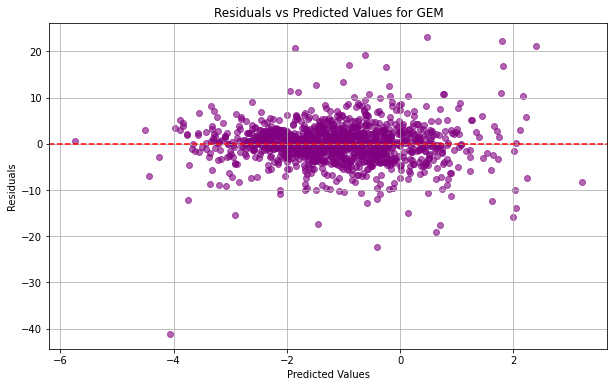

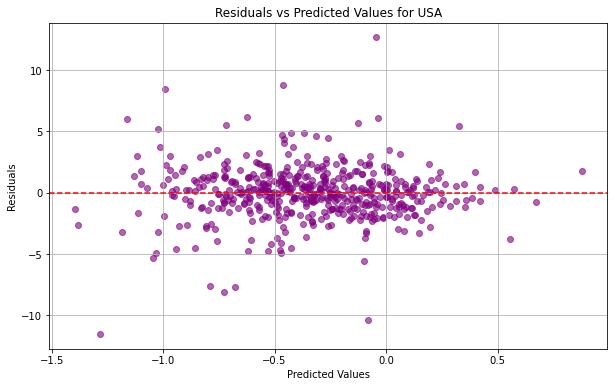

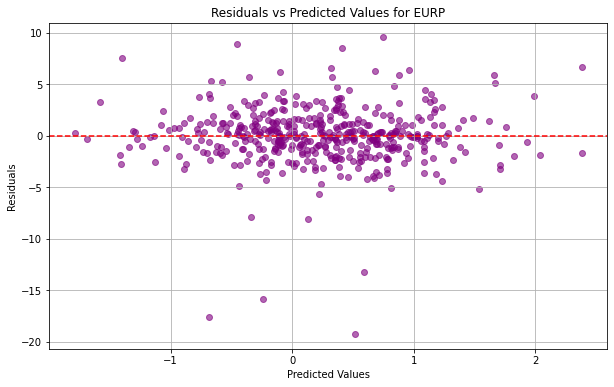

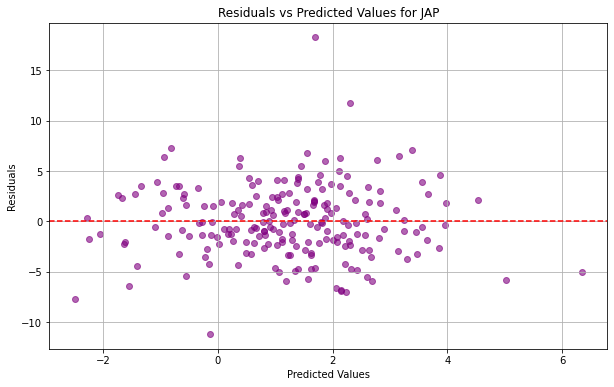

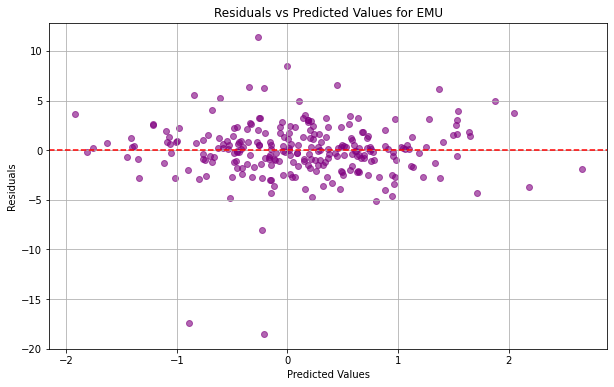

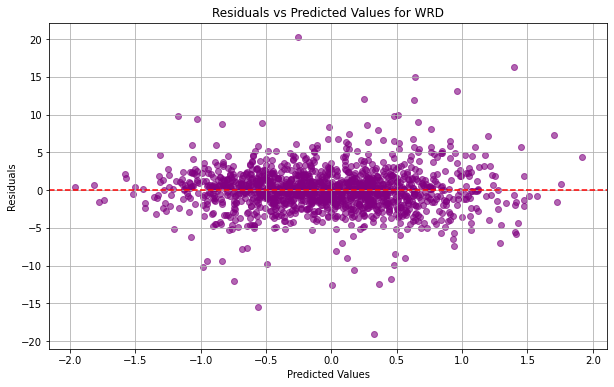

Email displayed successfully!


In [14]:
results = analyze_universes(Universe_mapping, from_date, to_date, Bystep, ByCurrency)


# Create an instance of the Outlook application
outlook = win32com.client.Dispatch("Outlook.Application")
namespace = outlook.GetNamespace("MAPI")


mail = outlook.CreateItem(0)  # 0: olMailItem

# Set email parameters
mail.To = "samuel.michaud@cpram.com"
mail.Subject = "Multi Regression for the week ending " + from_date

html_body = "Regression on Factors <br>"
html_body += " \n"

for universe, df in results.items():
    # Convert the DataFrame to HTML
    html_table = df.to_html(index=True)  # Convert DataFrame to HTML without index
    html_body += f"{universe}"  # Add the universe name as a header
    html_body += html_table  # Add the HTML table

html_body += ""  # Close the HTML tags

# Set the HTML body of the email
mail.HTMLBody = html_body

mail.Display()

print("Email displayed successfully!")

*Residual Definition of Residual \
*Mathematically, the residual for each observation can be expressed as: \
*[ \text{Residual} = \text{Actual Value} - \text{Predicted Value} ]

** DUMP

In [ ]:
#test to see
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

def analyze_universes1(Universe_mapping, from_date, to_date, Bystep, ByCurrency):
    results = {}  # Dictionary to store results for each universe
    lm = LinearRegression()  # Instantiate the linear regression model

    for universe_key in Universe_mapping.keys():
        uni = universe_key
        # Get data for the current universe
        df_pms = get_data(uni, from_date, to_date, Bystep, ByCurrency)

        # Define factors to look at based on the universe_key
        if uni == 'GEM':
            columns_to_keep = list(factor_mapping.values())[:-1]
        else:
            columns_to_keep = list(factor_mapping_WR.values())[:-1]

        Z = df_pms[columns_to_keep].fillna(0)
        Y = df_pms['PERF_W'].replace(np.nan, 0)  # This is a series
        lm.fit(Z, Y)

        intercept = lm.intercept_
        coefficients = lm.coef_

        # Calculate predictions and residuals
        predictions = lm.predict(Z)
        residuals = Y - predictions

        # Error Plot (Residuals)
        plt.figure(figsize=(10, 6))
        plt.scatter(predictions, residuals, color='purple', alpha=0.6)
        plt.axhline(0, color='red', linestyle='--')  # Horizontal line at 0
        plt.title(f'Residuals vs Predicted Values for {uni}')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.grid(True)
        plt.show()

        # Calculate the standard error of the residuals
        n = Z.shape[0]  # number of observations
        p = Z.shape[1]  # number of predictors
        residual_sum_of_squares = np.sum(residuals**2)
        standard_error = np.sqrt(residual_sum_of_squares / (n - p - 1))

        # Calculate the standard errors of the coefficients
        X_with_intercept = np.hstack((np.ones((Z.shape[0], 1)), Z))  # Add intercept to Z
        X_transpose_X_inv = np.linalg.inv(X_with_intercept.T @ X_with_intercept)
        standard_errors = standard_error * np.sqrt(np.diag(X_transpose_X_inv))

        # Calculate t-statistics
        t_stats = coefficients / standard_errors[1:]  # Exclude the intercept
        t_stat_intercept = intercept / standard_errors[0]  # Calculate t-statistic for the intercept

        # Create a DataFrame to display the results
        results_df = pd.DataFrame({
            'Variable': ['Intercept'] + list(Z.columns),
            'Coefficient': [intercept] + list(coefficients),
            'T-statistic': [t_stat_intercept] + list(t_stats)
        })

        # Set the Variable column as the index
        results_df.set_index('Variable', inplace=True)

        results[uni] = results_df
    
    return results

results = analyze_universes1(Universe_mapping, from_date, to_date, Bystep, ByCurrency)

*DUMP

In [7]:
#  for a % explaination of each variable

def analyze_universes5(Universe_mapping, from_date, to_date, Bystep, ByCurrency):
    results = {}  # Dictionary to store results for each universe
    lm = LinearRegression()  # Instantiate the linear regression model

    for universe_key in Universe_mapping.keys():
        uni = universe_key
        # Get data for the current universe
        df_pms = get_data(uni, from_date, to_date, Bystep, ByCurrency)

        # Check if df_pms is None or empty
        if df_pms is None or df_pms.empty:
            print(f"No data available for {uni}. Skipping this universe.")
            continue  # Skip to the next iteration

        # Define factors to look at based on the universe_key
        if uni == 'MMM':  # perso
            columns_to_keep = list(factor_mapping.values())[:-1]
        else:
            columns_to_keep = list(factor_mapping_WR.values())[:-1]

        Z = df_pms[columns_to_keep].fillna(0)
        Y = df_pms['PERF_W'].replace(np.nan, 0)  # This is a series
        lm.fit(Z, Y)

        # Calculate R-squared for the full model
        r_squared_full = lm.score(Z, Y)

        # Initialize a list to store partial R-squared values
        r2_reduced = []

        # Calculate partial R-squared for each variable
        for col in columns_to_keep:
            # Fit the reduced model excluding the current variable
            Z_reduced = Z.drop(columns=[col])
            lm_reduced = LinearRegression().fit(Z_reduced, Y)
            r_squared_reduced = lm_reduced.score(Z_reduced, Y)

            # Calculate partial R-squared
            partial_r_squared = r_squared_full - r_squared_reduced
            r2_reduced.append(partial_r_squared)

        # Calculate predictions and residuals
        predictions = lm.predict(Z)
        residuals = Y - predictions

        # Error Plot (Residuals)
        plt.figure(figsize=(10, 6))
        plt.scatter(predictions, residuals, color='purple', alpha=0.6)
        plt.axhline(0, color='red', linestyle='--')  # Horizontal line at 0
        plt.title(f'Residuals vs Predicted Values for {uni}')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.grid(True)
        plt.show()

        # Fit the model using statsmodels to get t-statistics
        Z_with_const = sm.add_constant(Z)  # Add constant for OLS
        model = sm.OLS(Y, Z_with_const).fit()  # Fit the OLS model

        # Get coefficients and t-statistics
        coefficients = model.params
        t_stats = model.tvalues

        # Create a DataFrame to display the results
        results_df = pd.DataFrame({
            'Variable': ['Intercept'] + list(Z.columns),
            'Coefficient': [model.params[0]] + list(model.params[1:]),  # Intercept and coefficients
            'T-statistic': [t_stats[0]] + list(t_stats[1:]),  # Intercept and t-statistics
            'r2_reduced': [np.nan] + r2_reduced  # Partial R-squared for each variable
        })

        # Set the Variable column as the index
        results_df.set_index('Variable', inplace=True)

        # Calculate r2_reduced as a percentage of r_squared_full
        results_df['r2_reduced'] = results_df['r2_reduced'] / r_squared_full * 100

        # Round the numerical columns to 2 decimal places
        results_df[['Coefficient', 'T-statistic', 'r2_reduced']] = results_df[['Coefficient', 'T-statistic', 'r2_reduced']].round(2)

        # Convert r2_reduced to string with percentage sign
        results_df['r2_reduced'] = results_df['r2_reduced'].astype(str) + '%'
        results_df['r2_reduced'] = results_df['r2_reduced'].replace('nan%', '', regex=True)
        results[uni] = results_df
    
    return results



In [33]:
# with sum of r2_reduced

def analyze_universes5(Universe_mapping, from_date, to_date, Bystep, ByCurrency):
    results = {}  # Dictionary to store results for each universe
    lm = LinearRegression()  # Instantiate the linear regression model

    for universe_key in Universe_mapping.keys():
        uni = universe_key
        # Get data for the current universe
        df_pms = get_data(uni, from_date, to_date, Bystep, ByCurrency)

        # Check if df_pms is None or empty
        if df_pms is None or df_pms.empty:
            print(f"No data available for {uni}. Skipping this universe.")
            continue  # Skip to the next iteration

        # Define factors to look at based on the universe_key
        if uni == 'MMM':  # perso
            columns_to_keep = list(factor_mapping.values())[:-1]
        else:
            columns_to_keep = list(factor_mapping_WR.values())[:-1]

        Z = df_pms[columns_to_keep].fillna(0)
        Y = df_pms['PERF_W'].replace(np.nan, 0)  # This is a series
        lm.fit(Z, Y)

        # Calculate R-squared for the full model
        r_squared_full = lm.score(Z, Y)

        # Initialize a list to store partial R-squared values
        r2_reduced = []

        # Calculate partial R-squared for each variable
        for col in columns_to_keep:
            # Fit the reduced model excluding the current variable
            Z_reduced = Z.drop(columns=[col])
            lm_reduced = LinearRegression().fit(Z_reduced, Y)
            r_squared_reduced = lm_reduced.score(Z_reduced, Y)

            # Calculate partial R-squared
            partial_r_squared = r_squared_full - r_squared_reduced
            r2_reduced.append(partial_r_squared)

        # Calculate predictions and residuals
        predictions = lm.predict(Z)
        residuals = Y - predictions

        # Error Plot (Residuals)
        # plt.figure(figsize=(10, 6))
        # plt.scatter(predictions, residuals, color='purple', alpha=0.6)
        # plt.axhline(0, color='red', linestyle='--')  # Horizontal line at 0
        # plt.title(f'Residuals vs Predicted Values for {uni}')
        # plt.xlabel('Predicted Values')
        # plt.ylabel('Residuals')
        # plt.grid(True)
        # plt.show()

        # distribution plot
        plt.figure(figsize=(10, 6))
        sns.kdeplot(Y, color='blue', label='Actual Values', fill=True, alpha=0.5)
        sns.kdeplot(predictions, color='purple', label='Predicted Values', fill=True, alpha=0.5)
        plt.title(f'Distribution of Actual vs Predicted Values for {uni}')
        plt.xlabel('Values')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Fit the model using statsmodels to get t-statistics
        Z_with_const = sm.add_constant(Z)  # Add constant for OLS
        model = sm.OLS(Y, Z_with_const).fit()  # Fit the OLS model

        # Get coefficients and t-statistics
        coefficients = model.params
        t_stats = model.tvalues

        #correlation bewteen factor
        correlation_matrix = Z.corr()
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=0)   #0 is the diagonal off
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, cbar_kws={"shrink": .8})
        plt.title(f'Correlation Matrix (Upper Half) : {uni}')
        plt.show()


        # Create a DataFrame to display the results
        results_df = pd.DataFrame({
            'Variable': ['Intercept'] + list(Z.columns),
            'Coefficient': [model.params[0]] + list(model.params[1:]),  # Intercept and coefficients
            'T-statistic': [t_stats[0]] + list(t_stats[1:]),  # Intercept and t-statistics
            'r2_reduced': [np.nan] + r2_reduced  # Partial R-squared for each variable
        })

        # Set the Variable column as the index
        results_df.set_index('Variable', inplace=True)

        # Calculate r2_reduced as a percentage of r_squared_full
        results_df['r2_reduced'] = results_df['r2_reduced'] / r_squared_full * 100

        # Round the numerical columns to 2 decimal places
        results_df[['Coefficient', 'T-statistic', 'r2_reduced']] = results_df[['Coefficient', 'T-statistic', 'r2_reduced']].round(2)

        # Convert r2_reduced to string with percentage sign
        results_df['r2_reduced'] = results_df['r2_reduced'].astype(str) + '%'
        results_df['r2_reduced'] = results_df['r2_reduced'].replace('nan%', '', regex=True)

        # Calculate the sum of r2_reduced (convert to float first, ignoring the '%')
        r2_reduced_sum = results_df['r2_reduced'].replace('', np.nan).str.rstrip('%').astype(float).sum()

        # Store the DataFrame and the sum of r2_reduced in the results dictionary
        results[uni] = {
            'data': results_df,  # Store the DataFrame
            'r2_reduced_sum': r2_reduced_sum  # Store the sum of r2_reduced
        }
    
    return results

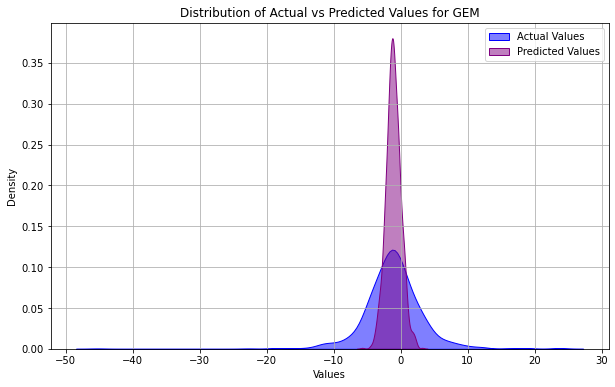

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


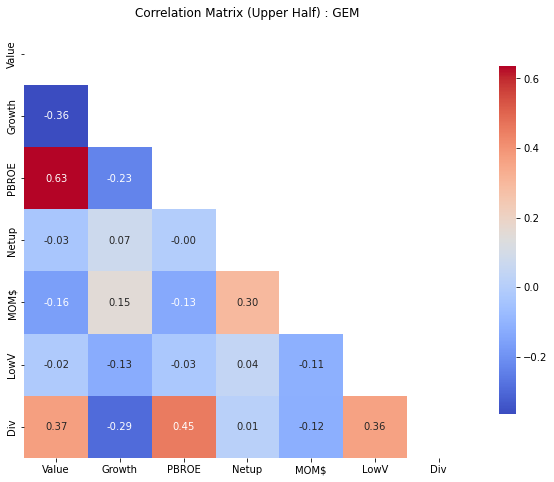

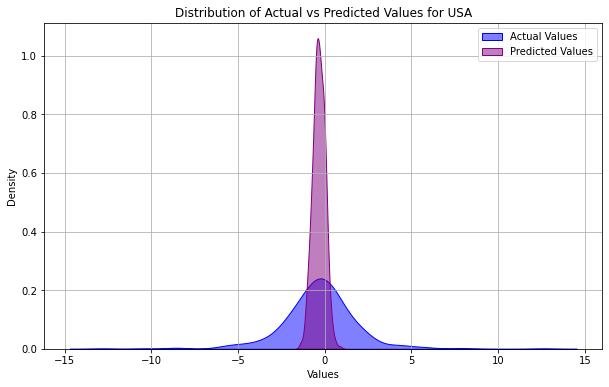

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


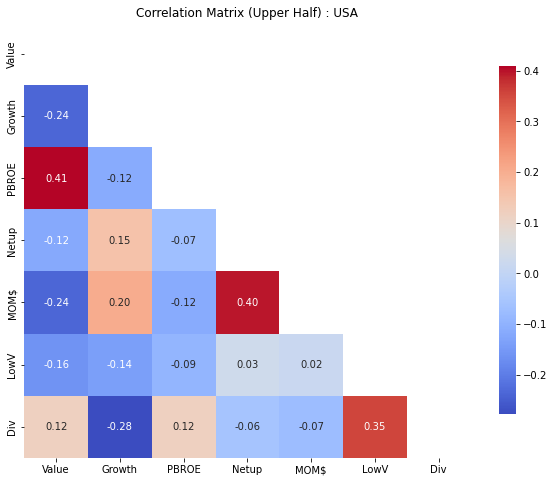

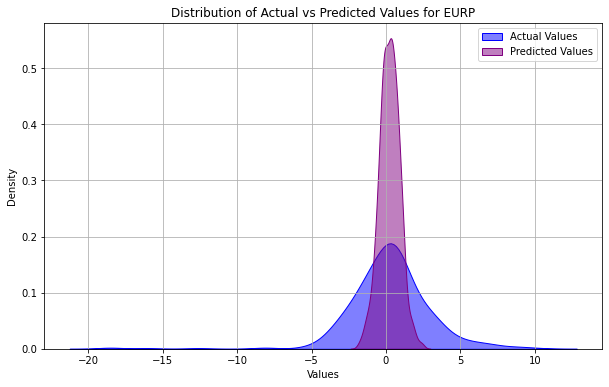

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


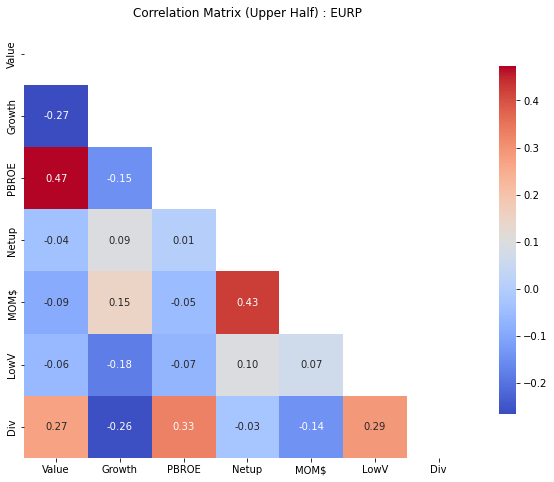

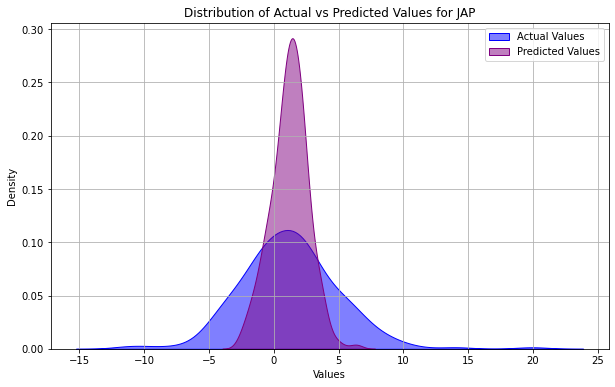

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


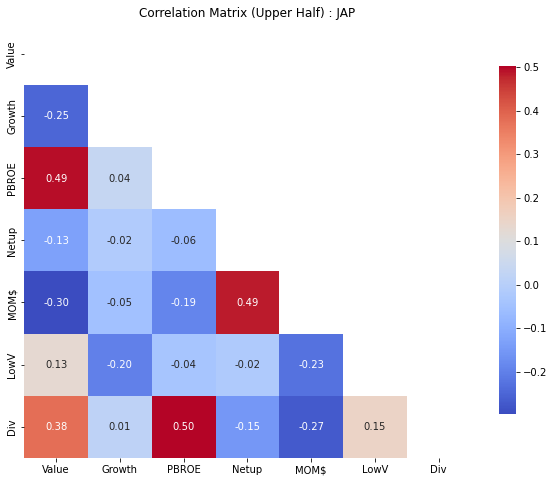

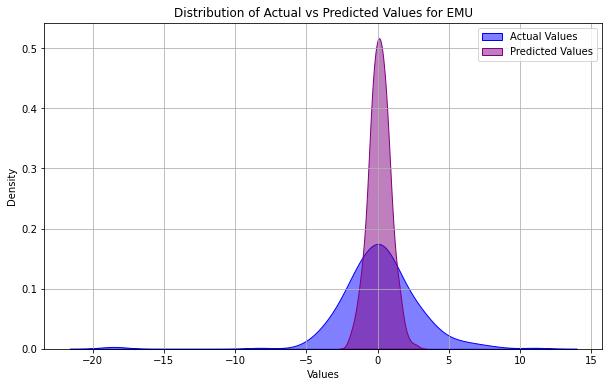

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


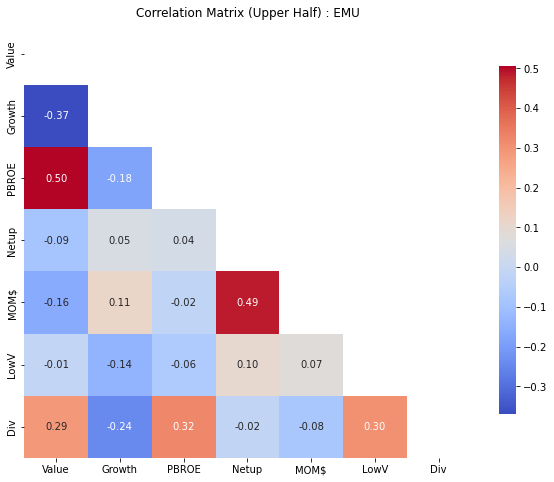

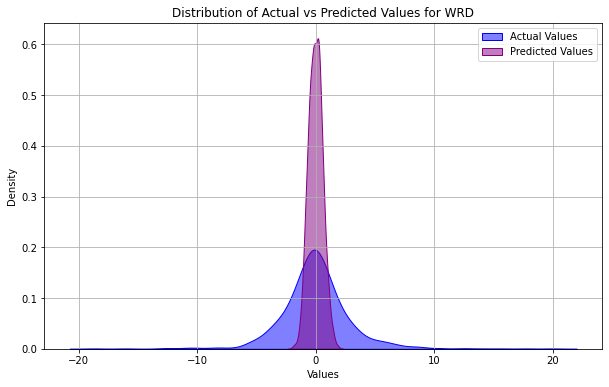

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


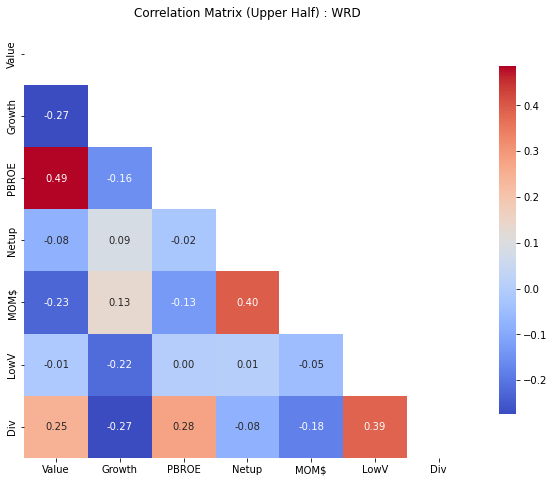

Email displayed successfully!


In [34]:
results = analyze_universes5(Universe_mapping, from_date, to_date, Bystep, ByCurrency)

# Create an instance of the Outlook application
outlook = win32com.client.Dispatch("Outlook.Application")
namespace = outlook.GetNamespace("MAPI")

mail = outlook.CreateItem(0)  # 0: olMailItem

# Set email parameters
mail.To = "samuel.michaud@cpram.com"
mail.Subject = "Multi Regression for the week ending " + from_date

html_body = "Regression on Factors <br>"
#html_body += ""  # Add an additional line break

for universe, result in results.items():
    df = result['data']  # Get the DataFrame
    r2_reduced_sum = result['r2_reduced_sum']  # Get the sum of r2_reduced

    # Convert the DataFrame to HTML
    html_table = df.to_html(index=True)  # Convert DataFrame to HTML with index
    html_body += f"{universe} - Sum of r2_reduced: {r2_reduced_sum:.2f}%"  # Add the universe name and sum as a header
    html_body += html_table  # Add the HTML table
    html_body += "<br>"

html_body += ""  # Close the HTML tags

# Set the HTML body of the email
mail.HTMLBody = html_body

mail.Display()

print("Email displayed successfully!")

In [ ]:
def analyze_universes5(Universe_mapping, from_date, to_date, Bystep, ByCurrency):
    results = {}  # Dictionary to store results for each universe
    lm = LinearRegression()  # Instantiate the linear regression model

    # Define the directory for saving graphs
    graphs_dir = r'P:\CPRAM\GESTION\ACTIONS\GFA_GQ_CPR\Samuel\Python\lm on EM\Graphs'
    os.makedirs(graphs_dir, exist_ok=True)  # Create the directory if it doesn't exist

    for universe_key in Universe_mapping.keys():
        uni = universe_key
        # Get data for the current universe
        df_pms = get_data(uni, from_date, to_date, Bystep, ByCurrency)

        # Check if df_pms is None or empty
        if df_pms is None or df_pms.empty:
            print(f"No data available for {uni}. Skipping this universe.")
            continue  # Skip to the next iteration

        # Define factors to look at based on the universe_key
        if uni == 'MMM':  # perso
            columns_to_keep = list(factor_mapping.values())[:-1]
        else:
            columns_to_keep = list(factor_mapping_WR.values())[:-1]

        Z = df_pms[columns_to_keep].fillna(0)
        Y = df_pms['PERF_W'].replace(np.nan, 0)  # This is a series
        lm.fit(Z, Y)

        # Calculate R-squared for the full model
        r_squared_full = lm.score(Z, Y)

        # Initialize a list to store partial R-squared values
        r2_reduced = []

        # Calculate partial R-squared for each variable
        for col in columns_to_keep:
            # Fit the reduced model excluding the current variable
            Z_reduced = Z.drop(columns=[col])
            lm_reduced = LinearRegression().fit(Z_reduced, Y)
            r_squared_reduced = lm_reduced.score(Z_reduced, Y)

            # Calculate partial R-squared
            partial_r_squared = r_squared_full - r_squared_reduced
            r2_reduced.append(partial_r_squared)

        # Calculate predictions and residuals
        predictions = lm.predict(Z)
        residuals = Y - predictions

        # Create a distribution plot
        plt.figure(figsize=(9, 5))
        sns.kdeplot(Y, color='blue', label='Actual Values', fill=True, alpha=0.5)
        sns.kdeplot(predictions, color='purple', label='Predicted Values', fill=True, alpha=0.5)
        plt.title(f'Distribution of Actual vs Predicted Values for {uni}')
        plt.xlabel('Values')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True)

        # Save the distribution plot to the specified directory
        plot_file = os.path.join(graphs_dir, f'{uni}_distribution.png')
        plt.savefig(plot_file)
        plt.close()  # Close the plot to free up memory

        # Fit the model using statsmodels to get t-statistics
        Z_with_const = sm.add_constant(Z)  # Add constant for OLS
        model = sm.OLS(Y, Z_with_const).fit()  # Fit the OLS model

        # Get coefficients and t-statistics
        coefficients = model.params
        t_stats = model.tvalues

        # Correlation between factors
        correlation_matrix = Z.corr()
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=0)  # Exclude the diagonal
        plt.figure(figsize=(9, 5))
        sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, cbar_kws={"shrink": .8})
        plt.title(f'Correlation Matrix (Upper Half) : {uni}')

        # Save the correlation plot to the specified directory
        correlation_plot_file = os.path.join(graphs_dir, f'{uni}_correlation.png')
        plt.savefig(correlation_plot_file)
        plt.close()  # Close the plot to free up memory

        # Create a DataFrame to display the results
        results_df = pd.DataFrame({
            'Variable': ['Intercept'] + list(Z.columns),
            'Coefficient': [model.params[0]] + list(model.params[1:]),  # Intercept and coefficients
            'T-stat': [t_stats[0]] + list(t_stats[1:]),  # Intercept and t-statistics
            'r2_red': [np.nan] + r2_reduced  # Partial R-squared for each variable
        })

        # Set the Variable column as the index
        results_df.set_index('Variable', inplace=True)

        # Calculate r2_reduced as a percentage of r_squared_full
        results_df['r2_red'] = results_df['r2_red'] / r_squared_full * 100

        # Round the numerical columns to 2 decimal places
        results_df[['Coefficient', 'T-stat', 'r2_red']] = results_df[['Coefficient', 'T-stat', 'r2_red']].round(2)

        # Convert r2_reduced to string with percentage sign
        results_df['r2_red'] = results_df['r2_red'].astype(str) + '%'
        results_df['r2_red'] = results_df['r2_red'].replace('nan%', '', regex=True)

        # Calculate the sum of r2_reduced (convert to float first, ignoring the '%')
        r2_reduced_sum = results_df['r2_red'].replace('', np.nan).str.rstrip('%').astype(float).sum()

        # Store the DataFrame and the sum of r2_reduced in the results dictionary
        results[uni] = {
            'data': results_df,  # Store the DataFrame
            'r2_reduced_sum': r2_reduced_sum,  # Store the sum of r2_reduced
            'plot_file': plot_file,  # Store the distribution plot file
            'correlation_plot_file': correlation_plot_file  # Store the correlation plot file
        }

    return results

# Call the function


# # Define the path where you want to save the Excel file
# today_date = datetime.now().strftime('%Y-%m-%d')
# file_path = rf'P:\CPRAM\GESTION\ACTIONS\GFA_GQ_CPR\Samuel\Python\lm on EM\lm on EM_{today_date}.xlsx'

# # Create an Excel writer object
# with pd.ExcelWriter(file_path, engine='xlsxwriter') as writer:
#     for universe, result in results.items():
#         df = result['data']  # Get the DataFrame for the universe
        
#         # Create a title for the DataFrame
#         title = f"{universe} - Sum of r2_reduced: {result['r2_reduced_sum']:.2f}%"
        
#         # Write the title to the Excel sheet
#         worksheet = writer.book.add_worksheet(universe)
#         worksheet.write('A1', title)  # Write the title in cell A1
        
#         # Write the DataFrame to the Excel sheet starting from row 2
#         df.to_excel(writer, sheet_name=universe, startrow=2, index=True)  # Save DataFrame to a sheet named after the universe
        
#         # Insert the distribution plot into the Excel sheet
#         worksheet.insert_image('E1', result['plot_file'])  # Adjust the cell location as needed
        
#         # Insert the correlation plot into the Excel sheet
#         worksheet.insert_image('Q1', result['correlation_plot_file'])  # Adjust the cell location as needed

# # Display the Excel file
# os.startfile(file_path)  # This will open the Excel file in the default application

# print("Excel file created with results and plots, and displayed successfully!")

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWa

In [46]:
def save_results_to_excel(results, base_path):

    file_path = rf'{base_path}\lm on EM_{from_date}.xlsx'

    # Create an Excel writer object
    with pd.ExcelWriter(file_path, engine='xlsxwriter') as writer:
        for universe, result in results.items():
            df = result['data']  # Get the DataFrame for the universe
            
            # Create a title for the DataFrame
            title = f"{universe} - Sum of r2_reduced: {result['r2_reduced_sum']:.2f}%"
            
            # Write the title to the Excel sheet
            worksheet = writer.book.add_worksheet(universe)
            worksheet.write('A1', title)  # Write the title in cell A1
            
            # Write the DataFrame to the Excel sheet starting from row 2
            df.to_excel(writer, sheet_name=universe, startrow=2, index=True)  # Save DataFrame to a sheet named after the universe
            
            # Insert the distribution plot into the Excel sheet
            worksheet.insert_image('E1', result['plot_file'])  # Adjust the cell location as needed
            
            # Insert the correlation plot into the Excel sheet
            worksheet.insert_image('Q1', result['correlation_plot_file'])  # Adjust the cell location as needed

    # Display the Excel file
    os.startfile(file_path)  # This will open the Excel file in the default application

    print("Excel file created with results and plots, and displayed successfully!")


In [ ]:
results = analyze_universes5(Universe_mapping, from_date, to_date, Bystep, ByCurrency)

save_results_to_excel(results, r'P:\CPRAM\GESTION\ACTIONS\GFA_GQ_CPR\Samuel\Python\lm on EM')

Excel file created with results and plots, and displayed successfully!
